# Wpływ rozmiaru modelu teoretycznego na bias i wariancje 

### Autorzy: Damian Horna 132240 Łukasz Eckert 132218

# Wprowadzenie 
Celem tego notebooka jest pokazanie zależności między biasem a wariancje w modelach SEIRD oraz SIR. Model SEIRD jest modelem posiadającym większą "moc". Posiada dwa dodatkowe parametry które mogą pomóc lepiej dopasować się do danych rzeczywistych. Dlatego też sądzimy, że powinnien mięć mniejszy bias. Co jednak z wariancją? 

# Wariancje 
Stwierdziliśmy, że nałatwiejszym sposobem na policzenie wariancji modelu, jest odporność tego modelu na szum losowy.

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import tqdm 

In [2]:
def deriv_seird(y, t, N, beta, gamma, delta, alpha, rho):
    S, E, I, R, D = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - delta * E
    dIdt = delta * E - (1 - alpha) * gamma * I - alpha * rho * I
    dRdt = (1 - alpha) * gamma * I
    dDdt = alpha * rho * I
    return dSdt, dEdt, dIdt, dRdt, dDdt
def deriv_sir(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma*I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

Wariancja będzie policzona w następujący sposób:
    1. Losowe parametry każdego modelu zostaną wybrane
    2. Następnie do wybranych parametrów zostanie dodany szum normalny o średniej 0 oraz wariancji 10% długości przedziału wartości
    3. Na danych z szumem zostanie przeprowadzony eksperyment
    4. Krok 2-3 zostaną powtórzony 100 razy.
    5. Wariancja zostanie policzona pomiędzy wszystkim pochodnymi symulacjami dla każdego z dni
    6. Wszystkie powrzysze kroki zostaną powtórzone 100 razy
    7. Średni wynik dla każdego dnia oraz obserwacji zostaną przedstawione na wykresach.

In [3]:
def run_seird():
    N = 60e6 #Stała wartość populacji
    S0, E0, I0, R0, D0 = N-1, 1, 0, 0, 0  # initial conditions: one exposed
    num_experiments = 100
    num_noise = 500
    res = []
    for _ in tqdm.tqdm(range(num_experiments)):
        beta = np.random.randint(3)+2 # Same as in UM project 
        delta = 1/(np.random.randint(10)+5)
        alpha = np.random.randint(99)*0.02+0.02
        rho = np.random.randint(11)+9
        gamma = 1/(np.random.randint(6)+4)

        sim = []
        for _ in range(num_noise):
            _beta = max(0, beta+np.random.normal(0, 0.02))
            _delta = max(0, delta+np.random.normal(0, (1/10-1/15)*0.01))
            _alpha = max(0, alpha+np.random.normal(0, 0.0018))
            _rho = max(0, rho+np.random.normal(0, 0.11))
            _gamma = max(0, gamma+np.random.normal(0, (1/4-1/6)*0.01))
            t = np.linspace(0, 46, 46)
            y0 = S0, E0, I0, R0, D0
            ret = odeint(deriv_seird, y0, t, args=(N, _beta, _gamma, _delta, _alpha, _rho))
            sim.append(ret)

        res.append(np.nanvar(np.array(sim),ddof=1, axis=0))
    return np.mean(np.array(res), axis=0)

def run_sir():
    N = 60e6 #Stała wartość populacji
    S0, I0, R0 = N-1, 1, 0  # initial conditions: one exposed
    num_experiments = 100
    num_noise = 500
    res = []
    for _ in tqdm.tqdm(range(num_experiments)):
        beta = np.random.randint(3)+2 # Same as in UM project 
        gamma = 1/(np.random.randint(6)+4)

        sim = []
        for _ in range(num_noise):
            _beta = max(0, beta+np.random.normal(0, 0.02))
            _gamma = max(0, gamma+np.random.normal(0, (1/4-1/6)*0.01))
            t = np.linspace(0, 46, 46)
            y0 = S0,I0, R0
            ret = odeint(deriv_sir, y0, t, args=(N, _beta, _gamma))
            sim.append(ret)

        res.append(np.nanvar(np.array(sim),ddof=1, axis=0))
    return np.mean(np.array(res), axis=0)
    


In [4]:
mean_sir = run_sir()
mean_seird = run_seird()


100%|██████████| 100/100 [01:43<00:00,  1.04s/it]


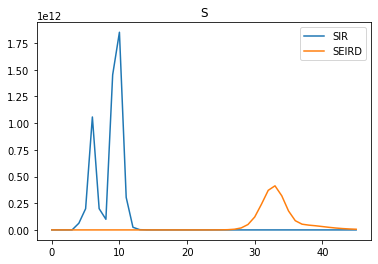

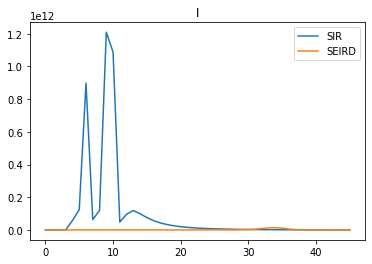

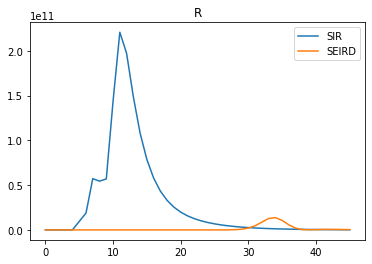

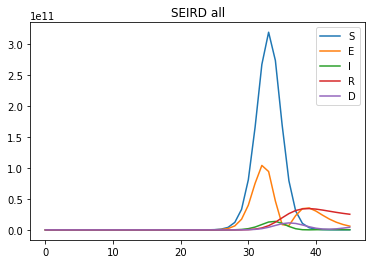

In [5]:
plt.plot(range(46), mean_sir[:, 0], label="SIR")
plt.plot(range(46), mean_seird[:, 0]+mean_seird[:, 1], label="SEIRD")
plt.legend()
plt.title("S")
plt.show()

plt.plot(range(46), mean_sir[:, 1], label="SIR")
plt.plot(range(46), mean_seird[:, 2], label="SEIRD")
plt.legend()
plt.title("I")
plt.show()

plt.plot(range(46), mean_sir[:, 2], label="SIR")
plt.plot(range(46), mean_seird[:, 2], label="SEIRD")
plt.legend()
plt.title("R")
plt.show()

for a, name in zip(range(5), ["S", "E", "I", "R", "D"]):
    plt.plot(range(46), mean_seird[:, a], label=name)
plt.legend()
plt.title("SEIRD all")
plt.show()

5,10,15,30,46 następnych dni

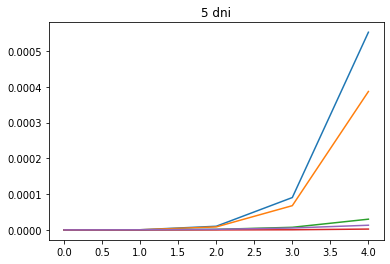

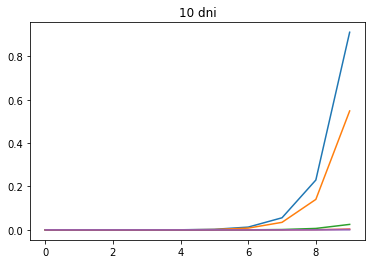

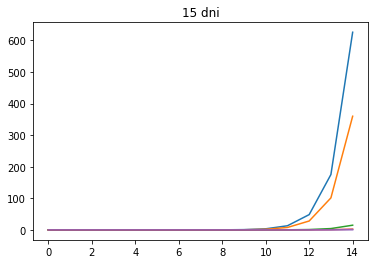

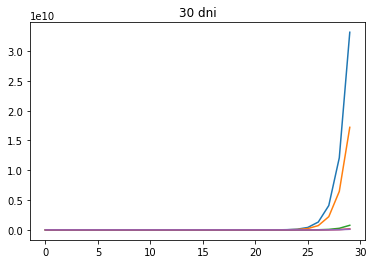

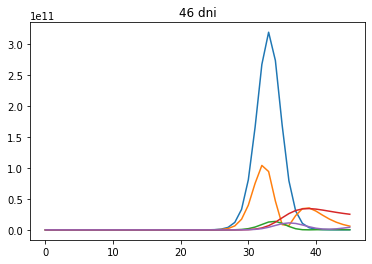

In [6]:
for a, name in zip(range(5), ["S", "E", "I", "R", "D"]):
    plt.plot(range(5), mean_seird[:5, a], label=name)
plt.title("5 dni")
plt.show()
for a, name in zip(range(5), ["S", "E", "I", "R", "D"]):
    plt.plot(range(10), mean_seird[:10, a], label=name)
plt.title("10 dni")
plt.show()
for a, name in zip(range(5), ["S", "E", "I", "R", "D"]):
    plt.plot(range(15), mean_seird[:15, a], label=name)
plt.title("15 dni")
plt.show()
for a, name in zip(range(5), ["S", "E", "I", "R", "D"]):
    plt.plot(range(30), mean_seird[:30, a], label=name)
plt.title("30 dni")
plt.show()
for a, name in zip(range(5), ["S", "E", "I", "R", "D"]):
    plt.plot(range(46), mean_seird[:46, a], label=name)
plt.title("46 dni")
plt.show()

# Wnioski
Nawet małe różnice w wartościach parametrów mają duży wpływ na wygląd krzywych. Jest to zjawisko niebezpieczne. Większość modeli uczenia maszynowego będzie popełniać jakiś błąd. Średnia wariancja rośnie wraz ze wzrostem horyzontu czasowego. Dlatego przewidywanie jaka sytuacja wystąpi za dwa miesiące jest trudna, lub nawet niemożliwa do zrealizowania.

# Analityczne podjeście
Szukamy funkcji f(x) takiej która w "najlepszy" sposób przewiduje wartość szukanych wartości (S E I R D). 
W takim przypadku możemy zastosować metode najmniejszych kwadratówdo nauki regresji liniowej! Jednym ograniczeniem jest to, że nie jesteśmy w stanie przewidzeć wartości nie obecnych w danych



# Perfekcyjny świat
1. Dane zostały wygenerowane z modelu teoretycznego SEIRD
2. Mamy pełna informacje o świecie


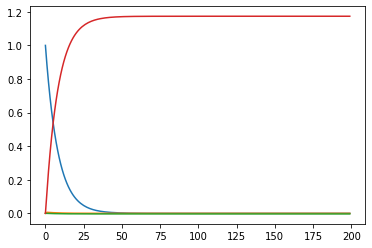

In [7]:
#Perfect data
 
beta = np.random.randint(3)+2 # Same as in UM project 
delta = 1/(np.random.randint(10)+5)
alpha = np.random.randint(99)*0.02+0.02
rho = np.random.randint(11)+9
gamma = 1/(np.random.randint(6)+4)
y0 = 1e6, 1, 0, 0, 0
t = np.linspace(0, 200, 200)
X = odeint(deriv_seird, y0, t, args=(1e6-1, beta, gamma, delta, alpha, rho))

# plt.plot(range(t.shape[0]), X[:,0])
plt.plot(range(t.shape[0]), X[:,1])
plt.plot(range(t.shape[0]), X[:,2])
plt.plot(range(t.shape[0]), X[:,3])
plt.plot(range(t.shape[0]), X[:,4])



/home/lukasz/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/lukasz/.local/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/lukasz/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pa

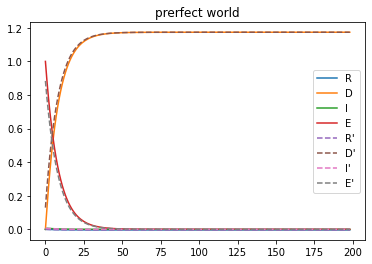

In [8]:
from sklearn.preprocessing import PolynomialFeatures
def rolling_sum(x):
    res = [x[0]]
    for a in x[1:]:
        res.append(res[-1]+a)
    return np.array(res)
def plot_experiment_perfect(X, pE, pR, pD, pI, name):
    plt.plot(range(X.shape[0]), X[:, 1],"-", label="R")
    plt.plot(range(X.shape[0]), X[:, 2],"-", label="D")
    plt.plot(range(X.shape[0]), X[:, 3],"-", label="I")
    plt.plot(range(X.shape[0]), X[:, 4],"-", label="E")

    plt.plot(range(X.shape[0]), pR,"--", label="R'")
    plt.plot(range(X.shape[0]), pD,"--", label="D'")
    plt.plot(range(X.shape[0]), pI,"--", label="I'")
    plt.plot(range(X.shape[0]), pE,"--", label="E'")
    plt.title(name)
    plt.legend()
    plt.show()
def run_experiment_perfect(E, R,D,I, num_days=1):
    e_target = np.array([x2-x1 for x1, x2 in zip(E, E[1:])])
    r_target = np.array([x2-x1 for x1, x2 in zip(R, R[1:])])
    d_target = np.array([x2-x1 for x1, x2 in zip(D, D[1:])])
    i_target = np.array([x2-x1 for x1, x2 in zip(I, I[1:])])
    X = []
    poz = 0
    while poz+num_days <= r_target.shape[0]:
        x = [1]
        for i in range(num_days):
            
            x.append(R[i+poz])
            x.append(D[i+poz])
            x.append(I[i+poz])
            x.append(E[i+poz])
        X.append(x)
        
        poz += 1
    pf = PolynomialFeatures(2) 
    X = np.array(X)
    X_org = X
    X = pf.fit_transform(X)
    e_m,_,_,_ = np.linalg.lstsq(X, e_target[num_days-1:])
    r_m,_,_,_ = np.linalg.lstsq(X, r_target[num_days-1:])
    d_m,_,_,_ = np.linalg.lstsq(X, d_target[num_days-1:])
    i_m,_,_,_ = np.linalg.lstsq(X, i_target[num_days-1:])
    
    r_e = rolling_sum(X.dot(e_m))+E[num_days-1]
    r_r = rolling_sum(X.dot(r_m))+R[num_days-1]
    r_d = rolling_sum(X.dot(d_m))+D[num_days-1]
    r_i = rolling_sum(X.dot(i_m))+I[num_days-1]
    
    return X_org, r_e, r_r, r_d, r_i
X_org, pE, pR, pD, pI = run_experiment_perfect(X[:,1], X[:,3], X[:,4], X[:,2], 1)
plot_experiment_perfect(X_org, pE, pR, pD, pI, "prerfect world")

Tak jak mogliśmy się spodziewać, otrzymujemy identyczne krzywe.

# Częściowo obserwowalny świat
Zdarza się, i tak jest w tym przypadku, że nie mamy informacji o wszystkich możliwych danych o świećie. Większość państw podaje tylko liczbę zainfekowanych, liczbę osób które zmarły lub wyzdrowiały. Jak w takim przypadku sprawdzi się ta metoda?

In [9]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
    
def run_experiment(R, D, I, num_days=1):
    r_target = np.array([x2-x1 for x1, x2 in zip(R, R[1:])])
    d_target = np.array([x2-x1 for x1, x2 in zip(D, D[1:])])
    i_target = np.array([x2-x1 for x1, x2 in zip(I, I[1:])])
    X = []
    poz = 0
    while poz+num_days <= r_target.shape[0]:
        x = [1]
        for i in range(num_days):
            
            x.append(R[i+poz])
            x.append(D[i+poz])
            x.append(I[i+poz])
        X.append(x)
        
        poz += 1
    pf = PolynomialFeatures(3)
    X = np.array(X)
    X_org = X
    X = pf.fit_transform(X)
   
    r_m,_,_,_ = np.linalg.lstsq(X, r_target[num_days-1:])
    d_m,_,_,_ = np.linalg.lstsq(X, d_target[num_days-1:])
    i_m,_,_,_ = np.linalg.lstsq(X, i_target[num_days-1:])

    
    return X_org, rolling_sum(X.dot(d_m))+R[num_days-1], X.dot(d_m)+D[num_days-1], X.dot(i_m)+I[num_days-1]

def plot_experiment(X, pR, pD, pI, name):
    plt.plot(range(X.shape[0]), X[:, 1],"-", label="R")
    plt.plot(range(X.shape[0]), X[:, 2],"-", label="D")
    plt.plot(range(X.shape[0]), X[:, 3],"-", label="I")

    plt.plot(range(X.shape[0]), pR,"--", label="R'")
    plt.plot(range(X.shape[0]), pD,"--", label="D'")
    plt.plot(range(X.shape[0]), pI,"--", label="I'")
    plt.title(name)
    plt.legend()
    plt.show()

/home/lukasz/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/lukasz/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/lukasz/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pa

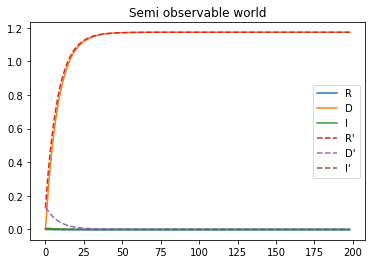

In [10]:
X, pR, pD, pI = run_experiment(X[:,3], X[:,4], X[:,2], 1)
plot_experiment(X, pR, pD, pI, "Semi observable world")

Jest już gorzej. Brak informacji sprawi problemy w estymacji stanu. Rzeczywista systuacja jest jeszcze gorsza!

# Rzeczywistość
W tym przykładzie wszystko jest nie tak.
1. Dane nie są w pełni obserwowalne
2. Nie mamy pewności, że dane pasują do modelu SEIRD (najmniejszy problem)
3. Istnieje duzy szum w samych danych. Ilość przeprowadzanych testów zależy od dnia (w soboty i niedziele będzie ich mniej). Zmienia się sytuacja w danym państwie i wiele innych
4. Nawet jeżeli dane pasują do modelu SEIRD, istnieje szansa, że parametry nie są stałe ale są pewnymi funkcji od czasu

Jedank sprawdzmy jak sobie poradzi proste przewidywanie parametrów

/home/lukasz/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/lukasz/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/lukasz/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pa

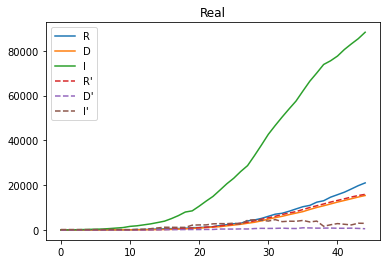

In [11]:
R = np.array([0, 0, 0, 1, 1, 1, 3, 45, 46, 50, 83, 149, 160, 276, 414, 523, 589, 622, 724, 1004, 1045, 1258, 1439, 1966, 2335, 2749, 2941, 4025, 4440, 5129, 6072, 7024, 7432, 8326, 9362, 10361, 10950, 12384, 13030, 14620, 15729, 16847, 18278, 19758, 20996, 21815])
D = np.array([0, 1, 2, 2, 5, 10, 12, 17, 21, 29, 34, 52, 79, 107, 148, 197, 233, 366, 463, 631, 827, 1016, 1266, 1441, 1809, 2158, 2503, 2978, 3405, 4032, 4825, 5476, 6077, 6820, 7503, 8165, 9134, 10023, 10779, 11591, 12428, 13155, 13915, 14681, 15362, 15887])
I = np.array([3, 19, 77, 129, 213, 311, 385, 588, 821, 1049, 1577, 1835, 2263, 2706, 3296, 3916, 5061, 6387, 7985, 8514, 10590, 12839, 14955, 17750, 20603, 23073, 26062, 28710, 33190, 37860, 42681, 46638, 50418, 54030, 57521, 62013, 66414, 70065, 73880, 75528, 77635, 80572, 83049, 85388, 88274, 91246])
bias = np.ones_like(R)
X = np.array([R,D,I, bias]).T
X, pR, pD, pI = run_experiment(X[:,0], X[:,1], X[:,2], 1)
plot_experiment(X, pR, pD, pI, "Real")

Porażka. Nie jesteśmy wstanie wyestymować tych parametrów w taki prosty sposób. 